In [188]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import calendar
from matplotlib import pyplot as plt
import scipy.stats as stats

In [189]:
from get_data_module import *
Get_data_Kanden()
Get_data_Toden()
# 東電の実績データ 単位[万kWh]	
df_toden = pd.read_csv('/Users/yusuke_miyazaki/Desktop/OneDrive/研究関連データ/data_for_project_spot_jikanmae/toden_jisseki.csv',index_col=0)
df_kanden = pd.read_csv('/Users/yusuke_miyazaki/Desktop/OneDrive/研究関連データ/data_for_project_spot_jikanmae/kanden_jisseki.csv',index_col=0)

/var/folders/c5/xmh5z7yd191cl82bdh1n_kzc0000gn/T/ipykernel_9498/272524289.py:5: DtypeWarning: Columns (3,5,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_toden = pd.read_csv('/Users/yusuke_miyazaki/Desktop/OneDrive/研究関連データ/data_for_project_spot_jikanmae/toden_jisseki.csv',index_col=0)


In [190]:
year = 2020

df_spot= pd.read_csv(f'/Users/yusuke_miyazaki/Desktop/OneDrive/研究関連データ/JEPX_tradedata/spot_{year}.csv',encoding='Shift-JIS')
df_jikanmae = pd.read_csv(f'/Users/yusuke_miyazaki/Desktop/OneDrive/研究関連データ/JEPX_tradedata/im_trade_summary_{year}.csv',encoding='Shift-JIS')

In [191]:
# DATE_TIMEの列を追加
# カラム名がDateとtimecode
def Create_Date_timecode(df):
    df = df.copy()
    Date_list = df['Date'].values
    Time_code = df['timecode'].values
    # 年月日と時刻コードを連結して
    Date_time_list = []
    for i in range(len(df)):
        Date_time = f'{Date_list[i]}_{Time_code[i]}'
        Date_time_list.append(Date_time)

    # df['Datetimes'] = Date_time_list
    df['DATE_timecode'] = Date_time_list
    return(df)

# カラム名がDateとTime
def Create_DateTime2(df):
    Date_Time_list = []
    Date_list = df['Date'].values
    Time_list = df['Time'].values
    for i in range(len(df)):
        Date = Date_list[i]
        Time = Time_list[i]
        str_datetime = f'{Date} {Time}'
        Date_Time_list.append(str_datetime)
    df['DATE_TIME'] = Date_Time_list

    return(df)


In [192]:
# スポット市場の約定量とシステムプライス
df_spot = df_spot.rename(columns={'システムプライス(円/kWh)':'spot_price',
                        '約定総量(kWh)':'volume_spot','年月日':'Date','時刻コード':'timecode'})

df_jikanmae = df_jikanmae.rename(columns={'平均（円/kWh）':'jikanmae_price',
                        '約定量合計（MWh/h）':'volume_jikanmae','年月日':'Date','時刻コード':'timecode'})

df_spot = Create_Date_timecode(df_spot)
df_jikanmae =Create_Date_timecode(df_jikanmae)


# DATE_timecode を軸として二つのdataframeを連結
df_merge = df_spot.merge(df_jikanmae,on='DATE_timecode')

# JEPXの値差の列を追加
df_merge['gap_price'] = df_merge['jikanmae_price'] - df_merge['spot_price']






In [193]:
# <<<<<<<<<<<<これは、発電とJEPXを合成するカーネル
df_toden = Create_DateTime2(df_toden)
df_hatuden_merge = df_toden.merge(df_kanden,on='DATE_TIME')
df_hatuden_merge['solar'] = df_hatuden_merge['太陽光発電実績']*10+df_hatuden_merge['太陽光実績〔MWh〕']
df_hatuden_merge['wind'] = df_hatuden_merge['風力発電実績']*10 + df_hatuden_merge['風力実績〔MWh〕']
df_hatuden_merge['solar+wind'] =df_hatuden_merge['solar'] + df_hatuden_merge['wind']

#####発電を合算したdataframeに時間コードを追加
# 時刻コード1が0:00,48が23:30,47は23:00
timecode = []
for str_time in df_hatuden_merge['Time'].values[:]:
    int_time = int(str_time.replace(':00',''))
    # print(int_time)
    if int_time==0:
        int_time=1
    else:
        int_time=int_time*2+1
    timecode.append(int_time)
df_hatuden_merge['timecode'] = timecode
######

########発電のdataframeにDATE_timecodeを追加

#//// 発電の日付を'2016/04/01'のような形にする そうしないとDATE_timecodeが一致しない
new_Date =[]
for str_date in df_hatuden_merge['Date'].values:
        #/で分割して再合成する
    date_split = str_date.split('/')
    date_year = date_split[0]
    date_month = date_split[1]
    date_day = date_split[2]
    if len(date_month)==1:
        date_month = '0'+date_month
    else:
        pass
    if (len(date_day)==1):
        date_day= '0'+date_day
        # 再合成  
    new_str_date = date_year+'/'+date_month+'/'+date_day
    # '2016/04/01'のような形にする。
    new_Date.append(new_str_date)
df_hatuden_merge['Date'] = new_Date
# ////

df_hatuden_merge = Create_Date_timecode(df_hatuden_merge)

# 発電のデータフレームとjepxのデータフレームを合体させる

df_king_merge = df_merge.merge(df_hatuden_merge,on='DATE_timecode')



In [194]:
# ////////ここからデータ分析

<AxesSubplot: ylabel='Frequency'>

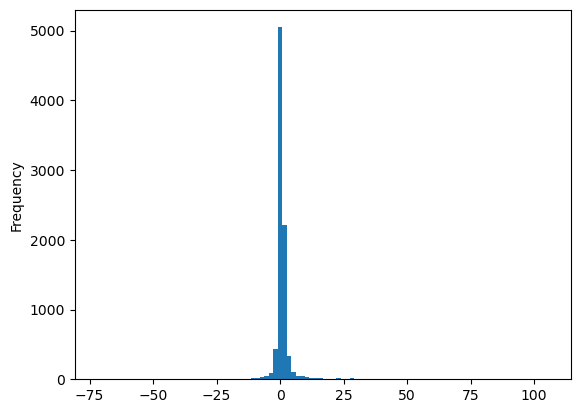

In [195]:
df_king_merge['gap_price'].plot.hist(bins=100)

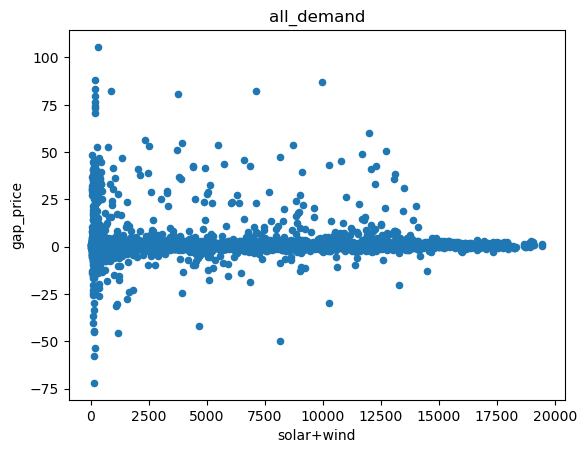

In [196]:
target ='solar+wind'
df_king_merge.plot.scatter(x=f'{target}',y='gap_price',title= 'all_demand')
plt.savefig(f'/Users/yusuke_miyazaki/Desktop/share_images/{target}_gapprice/{target}_all_demand.png')

<AxesSubplot: xlabel='solar+wind', ylabel='gap_price'>

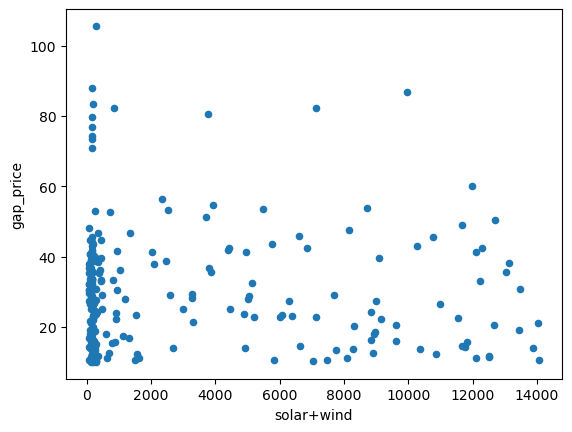

In [197]:
# gap_price が跳ね上がる時を抽出する
df_jamp = df_king_merge[df_king_merge['gap_price']>=10]

df_jamp.plot.scatter(x=f'{target}',y='gap_price')


In [198]:
df_toden

,Date,Time,東京エリア需要,原子力,火力,水力,地熱,バイオマス,太陽光発電実績,太陽光出力制御量,風力発電実績,風力出力制御量,揚水,連系線,合計,DATE_TIME
0,2016/4/1,0:00,"2,555",0,2258,92,0,2,0,0,2,0,0,201,"2,555",2016/4/1 0:00
1,2016/4/1,1:00,"2,433",0,2151,92,0,2,0,0,2,0,0,186,"2,433",2016/4/1 1:00
2,2016/4/1,2:00,"2,393",0,2117,92,0,2,0,0,2,0,0,180,"2,393",2016/4/1 2:00
3,2016/4/1,3:00,"2,375",0,2101,93,0,2,0,0,1,0,0,178,"2,375",2016/4/1 3:00
4,2016/4/1,4:00,"2,390",0,2125,93,0,2,0,0,1,0,0,169,"2,390",2016/4/1 4:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58435,2022/11/30,19:00,3243,0,2628,132,0,25,0,0,15,0,0,443,3243,2022/11/30 19:00
58436,2022/11/30,20:00,3122,0,2526,119,0,25,0,0,16,0,4,432,3122,2022/11/30 20:00
58437,2022/11/30,21:00,2974,0,2397,113,0,24,0,0,17,0,14,409,2974,2022/11/30 21:00
58438,2022/11/30,22:00,2846,0,2335,106,0,24,0,0,18,0,-3,366,2846,2022/11/30 22:00


In [199]:
df_kanden

,DATE_TIME,エリア需要〔MWh〕,原子力〔MWh〕,火力〔MWh〕,水力〔MWh〕,地熱〔MWh〕,バイオマス〔MWh〕,太陽光実績〔MWh〕,太陽光抑制量〔MWh〕,風力実績〔MWh〕,風力抑制量〔MWh〕,揚水〔MWh〕,連系線〔MWh〕
0,2016/4/1 0:00,12918,0,10405,758,0,0,0,0,41,0,89,1625
1,2016/4/1 1:00,12835,0,10453,580,0,0,0,0,24,0,0,1778
2,2016/4/1 2:00,13351,0,10952,528,0,0,0,0,27,0,0,1844
3,2016/4/1 3:00,13591,0,11327,491,0,0,0,0,29,0,0,1744
4,2016/4/1 4:00,13307,0,11140,479,0,0,0,0,34,0,0,1654
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57715,2022/10/31 19:00,15354,2877,8394,1490,0,67,0,0,5,0,154,2368
57716,2022/10/31 20:00,14748,2877,8148,1392,0,67,0,0,4,0,94,2166
57717,2022/10/31 21:00,14230,2877,7905,1007,0,67,0,0,4,0,0,2369
57718,2022/10/31 22:00,13689,2878,7533,895,0,67,0,0,3,0,0,2312


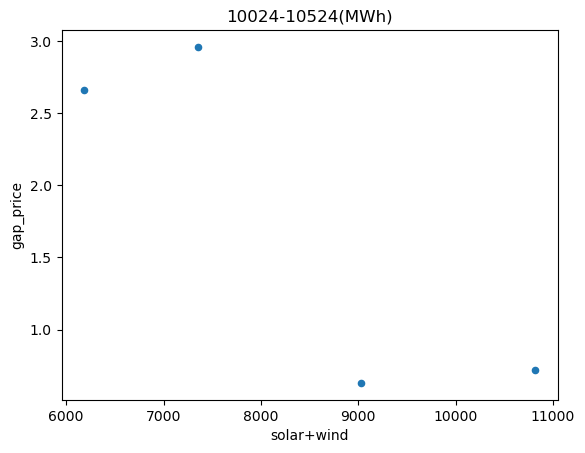

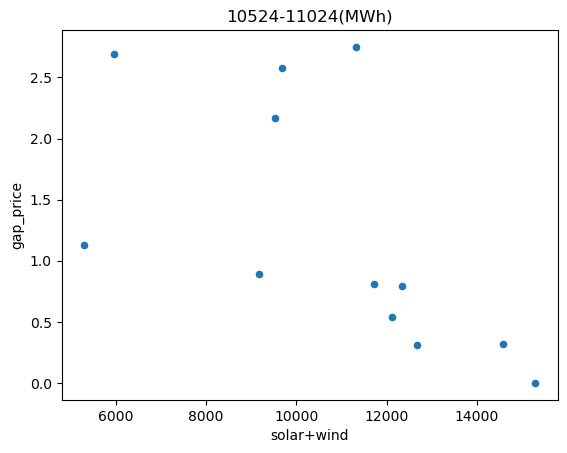

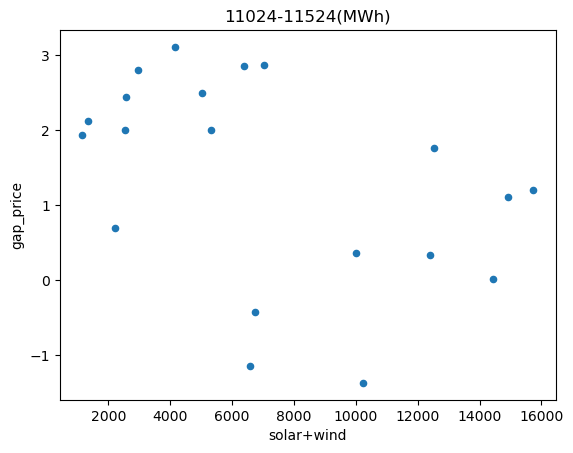

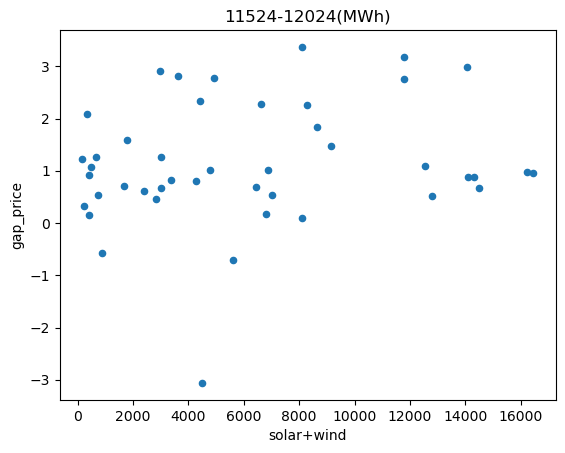

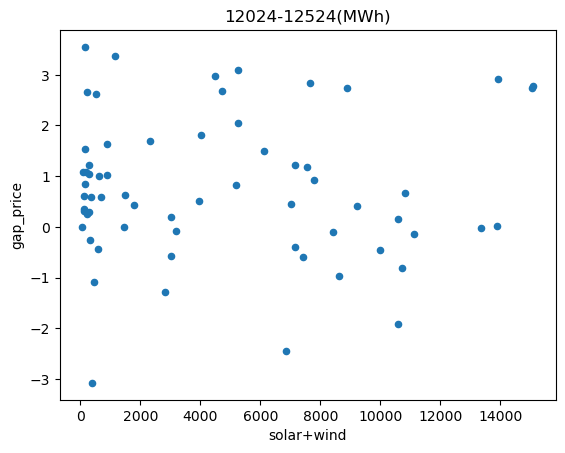

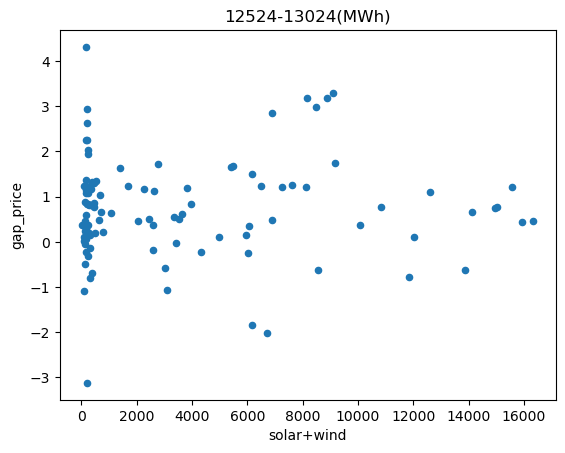

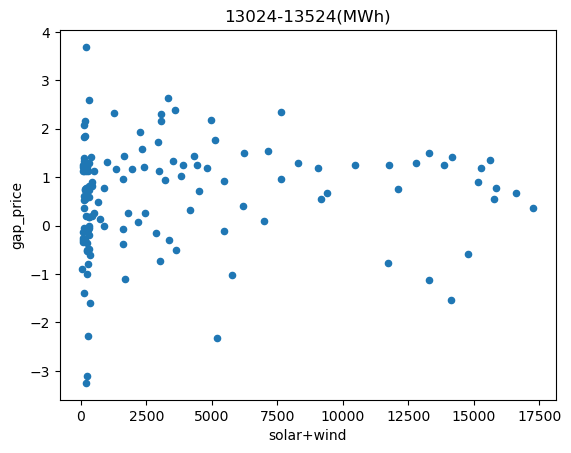

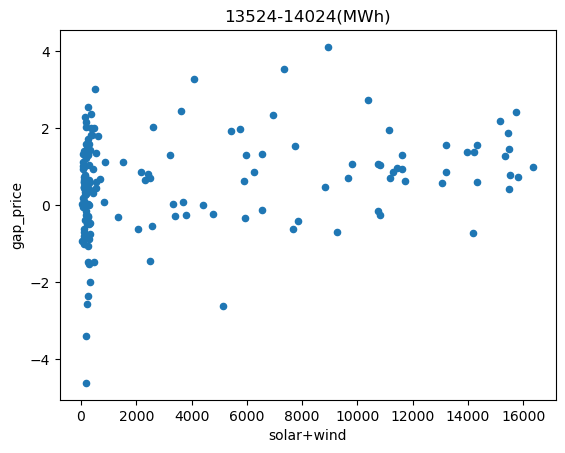

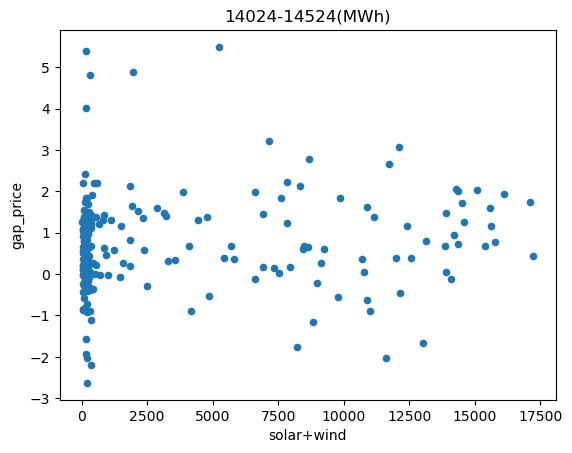

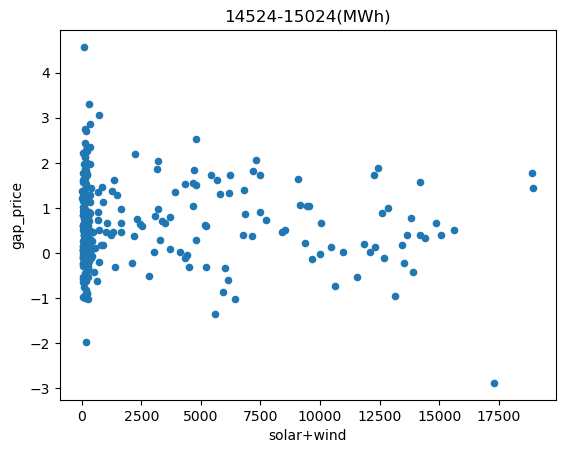

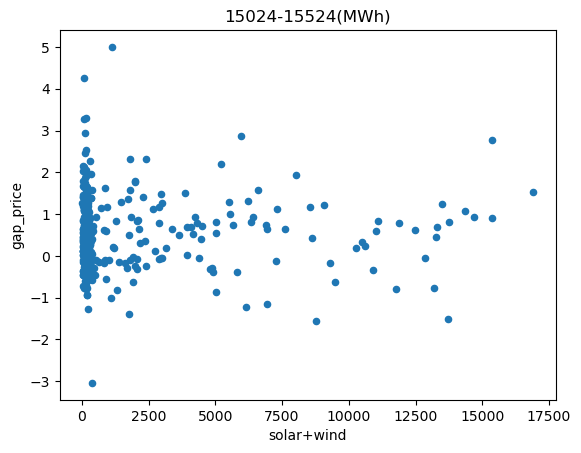

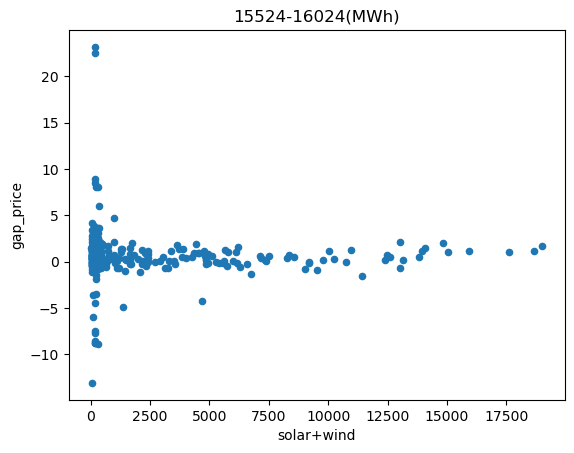

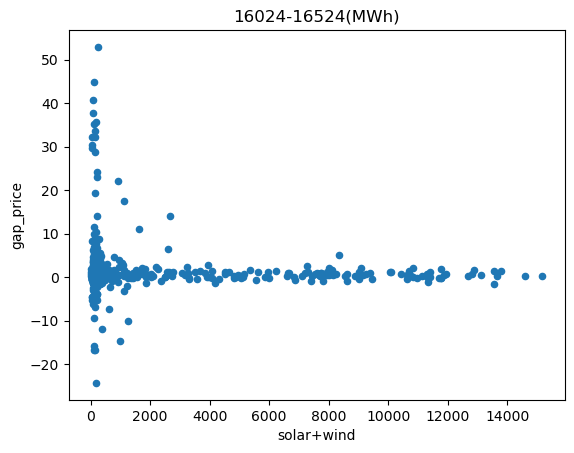

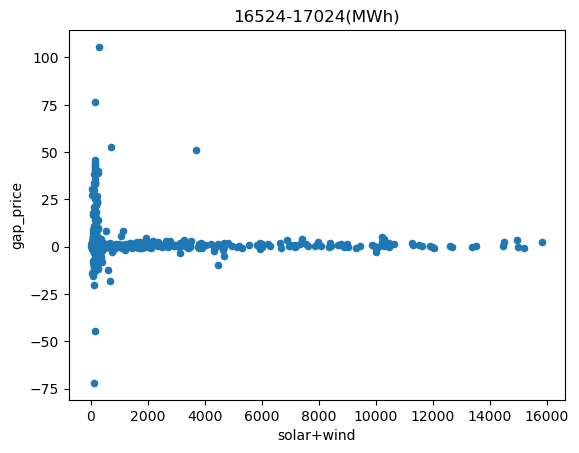

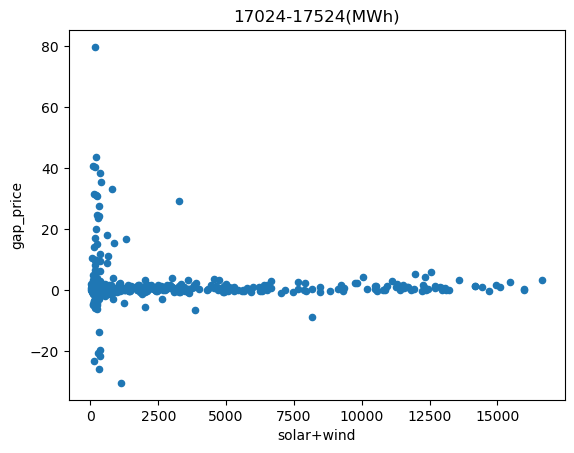

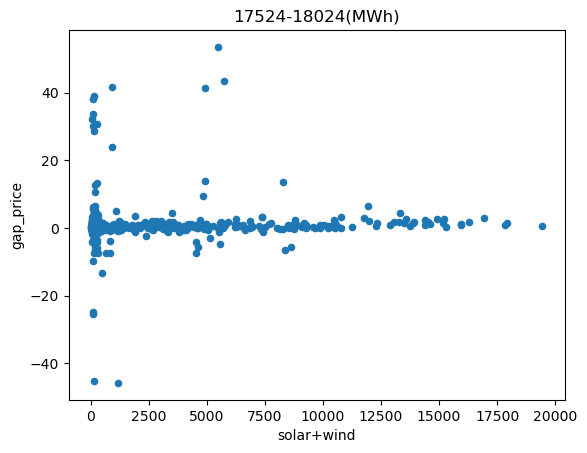

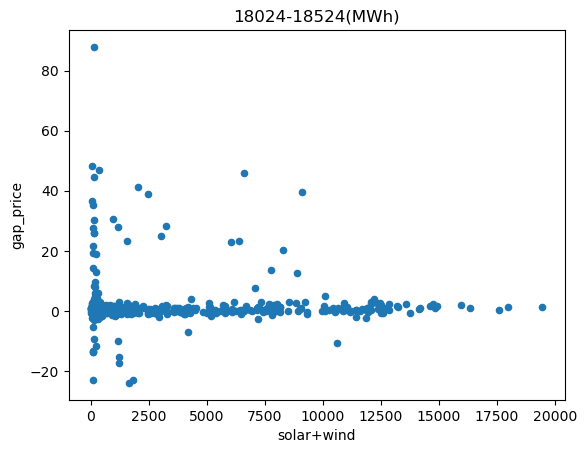

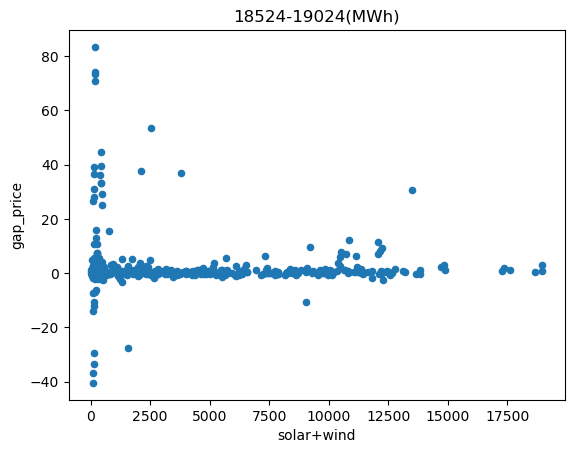

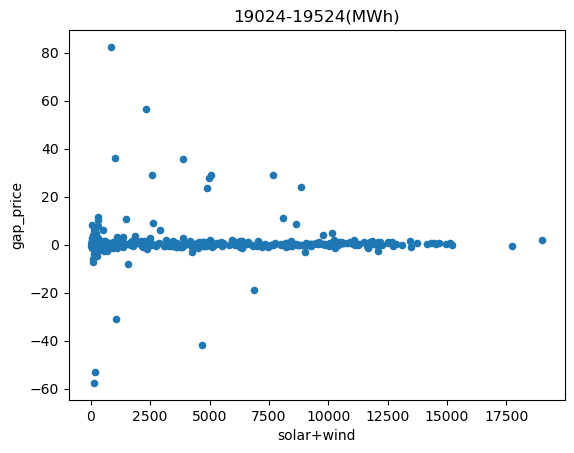

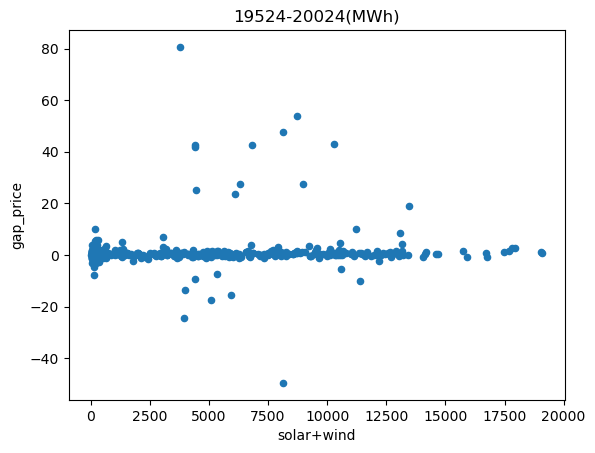

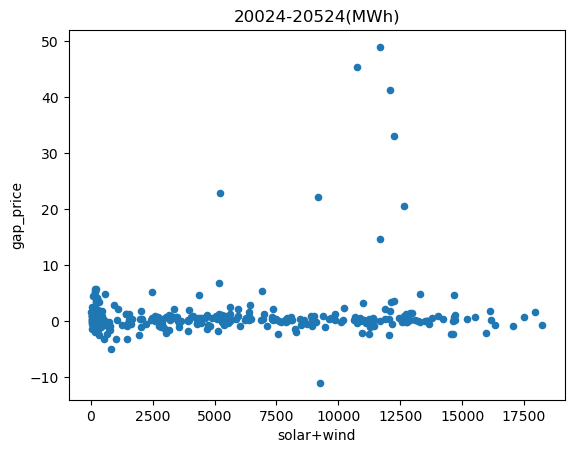

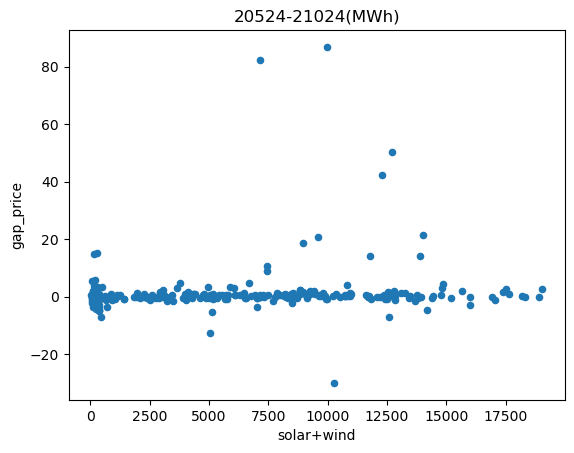

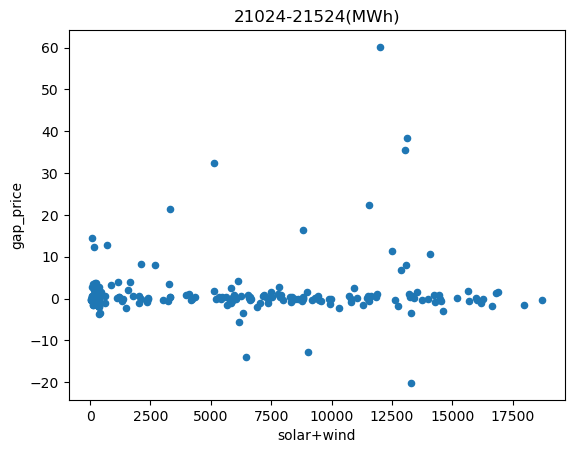

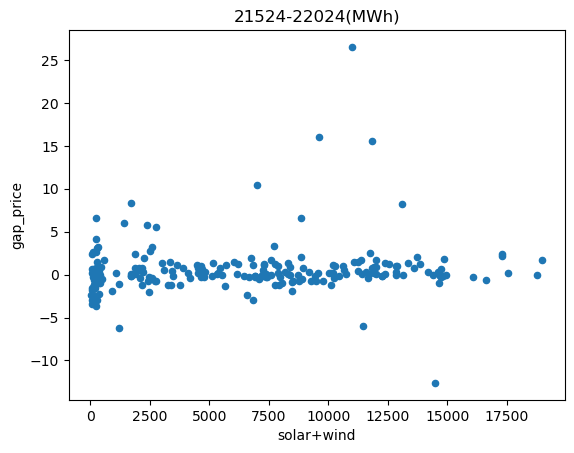

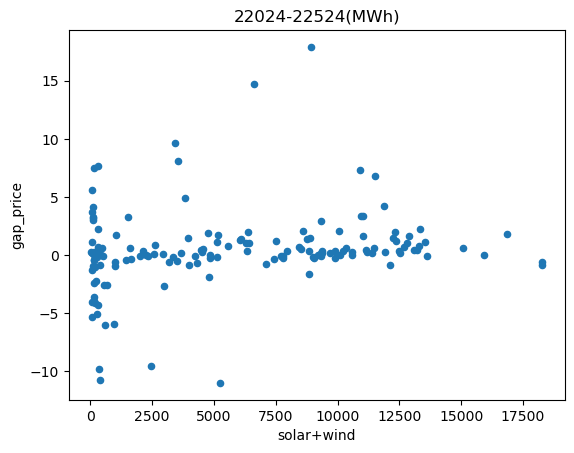

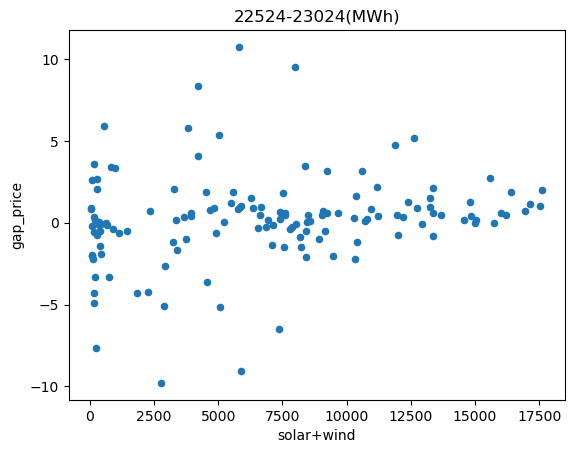

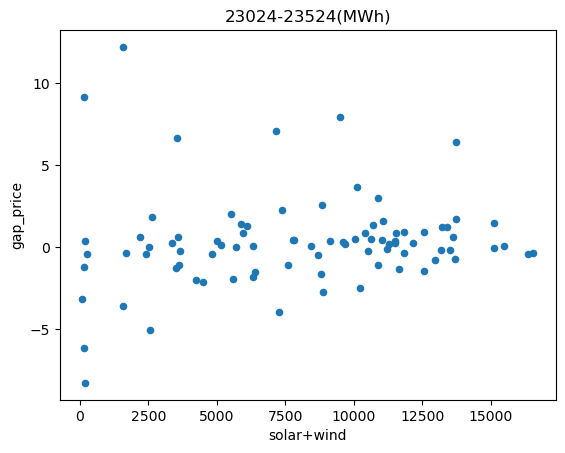

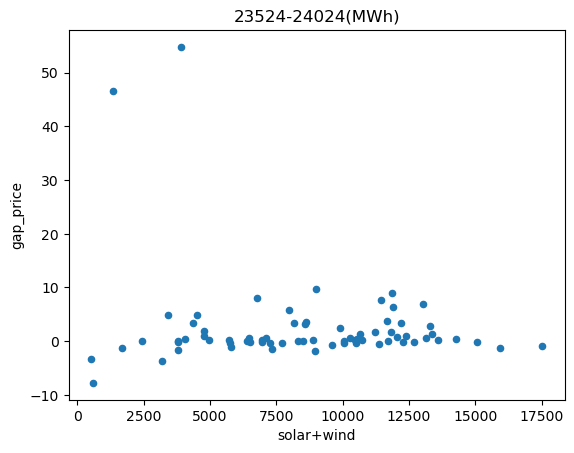

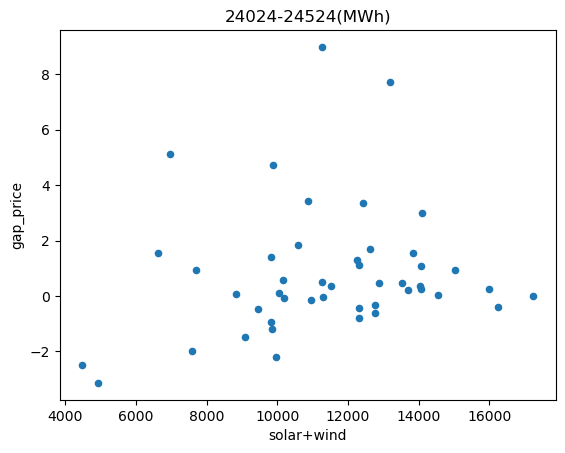

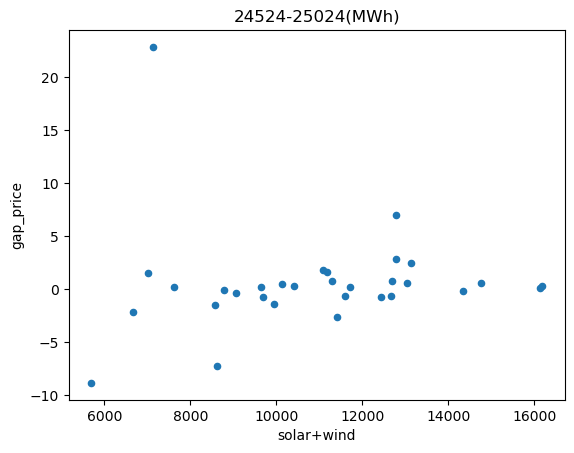

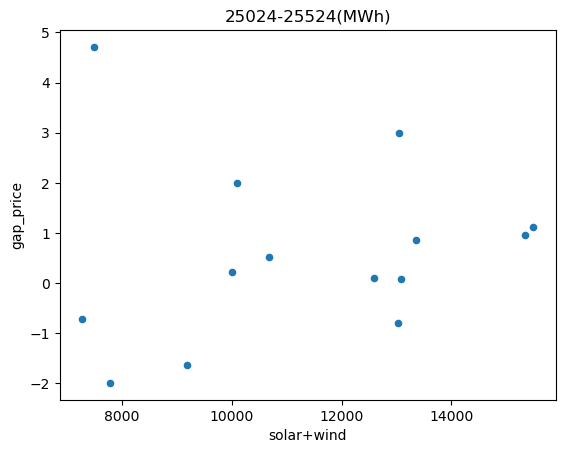

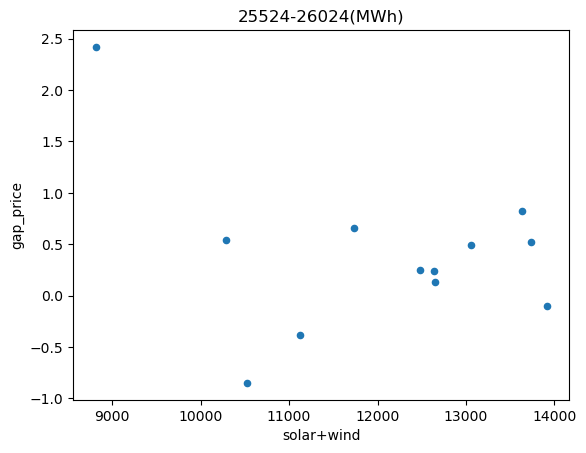

In [200]:
# スポットの電力需要ごとに分ける。

volume_spot = df_king_merge['volume_spot'].values
min_volume_spot =np.min(volume_spot)
max_volume_spot = np.max(volume_spot)
# 1000MWhずつのとき1000*1000
MWh_range = 500*1000
plot_num =int((max_volume_spot-min_volume_spot)/MWh_range)

for num in range(0,plot_num):

    start_point = min_volume_spot+MWh_range*num
    end_point=min_volume_spot+MWh_range*(num+1)
    df_select = df_king_merge[(df_king_merge['volume_spot']>= start_point ) & (df_king_merge['volume_spot']<= end_point)]

    df_select.plot.scatter(x=f'{target}',y='gap_price',title=f'{int(start_point/1000)}-{int(end_point/1000)}(MWh)')
    plt.savefig(f'/Users/yusuke_miyazaki/Desktop/share_images/{target}_gapprice/{target}_gapprice_figure{num}.png')
    plt.show()


In [201]:
df_king_merge

,Date_x,timecode_x,売り入札量(kWh),買い入札量(kWh),volume_spot,spot_price,エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),...,太陽光実績〔MWh〕,太陽光抑制量〔MWh〕,風力実績〔MWh〕,風力抑制量〔MWh〕,揚水〔MWh〕,連系線〔MWh〕,solar,wind,solar+wind,timecode
0,2020/04/01,1,16592450,18033600,15772950,6.43,6.84,6.76,6.76,4.00,...,0,0,24,0,-829,591,0,134,134,1
1,2020/04/01,3,17263950,18234450,15990350,5.18,6.61,6.61,6.61,4.09,...,0,0,24,0,-748,250,0,134,134,3
2,2020/04/01,5,17943550,18738950,16338200,4.87,6.51,6.51,6.51,4.09,...,0,0,25,0,-455,144,0,135,135,5
3,2020/04/01,7,18271250,18893350,16503500,4.50,6.50,6.50,6.50,4.43,...,0,0,29,0,-21,141,0,129,129,7
4,2020/04/01,9,18372800,18952050,16682800,4.43,6.50,6.50,6.50,4.00,...,0,0,33,0,-173,401,0,103,103,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021/03/31,39,23754400,21264050,16500150,6.38,6.38,6.38,6.38,6.38,...,0,0,27,0,197,2603,0,147,147,39
8756,2021/03/31,41,23133850,21073750,16536050,5.56,5.56,5.56,5.56,5.56,...,0,0,45,0,191,2413,0,165,165,41
8757,2021/03/31,43,23006900,20875500,16672750,5.73,5.73,5.73,5.73,5.73,...,0,0,36,0,193,2425,0,156,156,43
8758,2021/03/31,45,21547800,20580150,15683350,5.35,5.35,5.35,5.35,5.35,...,0,0,25,0,206,2685,0,145,145,45


In [204]:
df_kanden['太陽光抑制量〔MWh〕'].values.max()

23

In [205]:
df_toden['風力出力制御量'].values.min()

0

In [206]:
df_toden

,Date,Time,東京エリア需要,原子力,火力,水力,地熱,バイオマス,太陽光発電実績,太陽光出力制御量,風力発電実績,風力出力制御量,揚水,連系線,合計,DATE_TIME
0,2016/4/1,0:00,"2,555",0,2258,92,0,2,0,0,2,0,0,201,"2,555",2016/4/1 0:00
1,2016/4/1,1:00,"2,433",0,2151,92,0,2,0,0,2,0,0,186,"2,433",2016/4/1 1:00
2,2016/4/1,2:00,"2,393",0,2117,92,0,2,0,0,2,0,0,180,"2,393",2016/4/1 2:00
3,2016/4/1,3:00,"2,375",0,2101,93,0,2,0,0,1,0,0,178,"2,375",2016/4/1 3:00
4,2016/4/1,4:00,"2,390",0,2125,93,0,2,0,0,1,0,0,169,"2,390",2016/4/1 4:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58435,2022/11/30,19:00,3243,0,2628,132,0,25,0,0,15,0,0,443,3243,2022/11/30 19:00
58436,2022/11/30,20:00,3122,0,2526,119,0,25,0,0,16,0,4,432,3122,2022/11/30 20:00
58437,2022/11/30,21:00,2974,0,2397,113,0,24,0,0,17,0,14,409,2974,2022/11/30 21:00
58438,2022/11/30,22:00,2846,0,2335,106,0,24,0,0,18,0,-3,366,2846,2022/11/30 22:00


In [207]:
# 発電の日付を'2016/04/01'のような形にする
new_Date =[]

for str_date in df_hatuden_merge['Date'].values:

    date_split = str_date.split('/')
    date_year = date_split[0]
    date_month = date_split[1]
    date_day = date_split[2]
    if len(date_month)==1:
        date_month = '0'+date_month
    else:
        pass
    if (len(date_day)==1):
        date_day= '0'+date_day

    new_str_date = date_year+'/'+date_month+'/'+date_day
    # '2016/04/01'のような形にする。
    new_Date.append(new_str_date)
    
df_hatuden_merge['Date'] = new_Date

In [208]:
len(date_month)

2

In [209]:
'0'+date_month

'010'

In [210]:
new_Date

['2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/01',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/02',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/03',
 '2016/04/

In [211]:
df_merge['時刻コード_x'].values.min()

KeyError: '時刻コード_x'

In [212]:
# 時刻コード1が0:00,48が23:30,47は23:00
timecode = []
for str_time in df_hatuden_merge['Time'].values[:]:
    int_time = int(str_time.replace(':00',''))
    # print(int_time)
    if int_time==0:
        int_time=1
    else:
        int_time=int_time*2+1
    timecode.append(int_time)
    
df_hatuden_merge['timecode'] = timecode

In [213]:
df_hatuden_merge

,Date,Time,東京エリア需要,原子力,火力,水力,地熱,バイオマス,太陽光発電実績,太陽光出力制御量,...,太陽光抑制量〔MWh〕,風力実績〔MWh〕,風力抑制量〔MWh〕,揚水〔MWh〕,連系線〔MWh〕,solar,wind,solar+wind,timecode,DATE_timecode
0,2016/04/01,0:00,"2,555",0,2258,92,0,2,0,0,...,0,41,0,89,1625,0,61,61,1,2016/04/01_1
1,2016/04/01,1:00,"2,433",0,2151,92,0,2,0,0,...,0,24,0,0,1778,0,44,44,3,2016/04/01_3
2,2016/04/01,2:00,"2,393",0,2117,92,0,2,0,0,...,0,27,0,0,1844,0,47,47,5,2016/04/01_5
3,2016/04/01,3:00,"2,375",0,2101,93,0,2,0,0,...,0,29,0,0,1744,0,39,39,7,2016/04/01_7
4,2016/04/01,4:00,"2,390",0,2125,93,0,2,0,0,...,0,34,0,0,1654,0,44,44,9,2016/04/01_9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53347,2022/10/31,19:00,3200,0,2761,122,0,29,0,0,...,0,5,0,154,2368,0,95,95,39,2022/10/31_39
53348,2022/10/31,20:00,3083,0,2650,117,0,29,0,0,...,0,4,0,94,2166,0,84,84,41,2022/10/31_41
53349,2022/10/31,21:00,2928,0,2556,102,0,27,0,0,...,0,4,0,0,2369,0,84,84,43,2022/10/31_43
53350,2022/10/31,22:00,2795,0,2411,88,0,25,0,0,...,0,3,0,0,2312,0,73,73,45,2022/10/31_45


In [214]:
int(str_time.replace(':00',''))

23

In [215]:
df_kanden

,DATE_TIME,エリア需要〔MWh〕,原子力〔MWh〕,火力〔MWh〕,水力〔MWh〕,地熱〔MWh〕,バイオマス〔MWh〕,太陽光実績〔MWh〕,太陽光抑制量〔MWh〕,風力実績〔MWh〕,風力抑制量〔MWh〕,揚水〔MWh〕,連系線〔MWh〕
0,2016/4/1 0:00,12918,0,10405,758,0,0,0,0,41,0,89,1625
1,2016/4/1 1:00,12835,0,10453,580,0,0,0,0,24,0,0,1778
2,2016/4/1 2:00,13351,0,10952,528,0,0,0,0,27,0,0,1844
3,2016/4/1 3:00,13591,0,11327,491,0,0,0,0,29,0,0,1744
4,2016/4/1 4:00,13307,0,11140,479,0,0,0,0,34,0,0,1654
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57715,2022/10/31 19:00,15354,2877,8394,1490,0,67,0,0,5,0,154,2368
57716,2022/10/31 20:00,14748,2877,8148,1392,0,67,0,0,4,0,94,2166
57717,2022/10/31 21:00,14230,2877,7905,1007,0,67,0,0,4,0,0,2369
57718,2022/10/31 22:00,13689,2878,7533,895,0,67,0,0,3,0,0,2312


In [216]:
st

NameError: name 'st' is not defined

<AxesSubplot: xlabel='spot_price', ylabel='volume_jikanmae'>

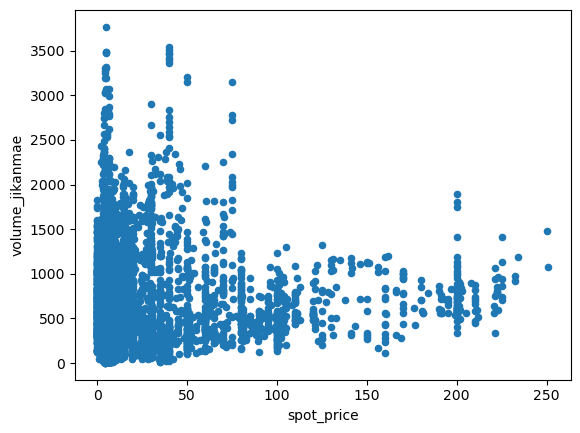

In [220]:
df_merge.plot.scatter(x="spot_price",y="volume_jikanmae")

In [217]:
# df_merge

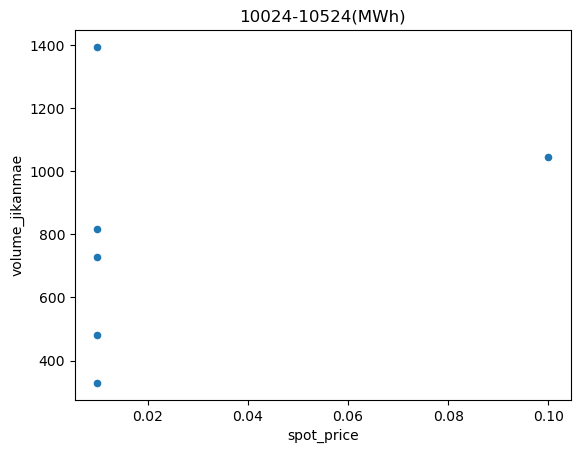

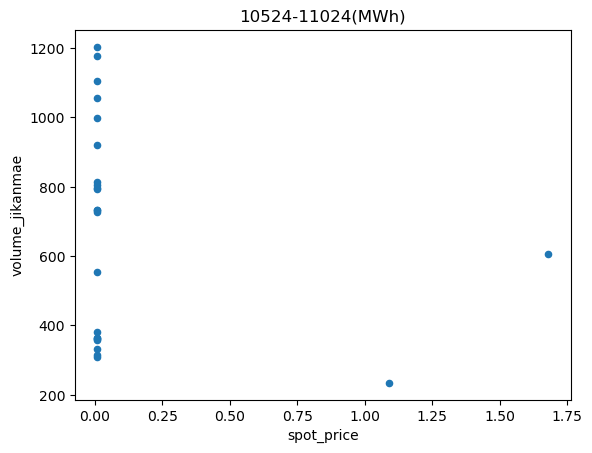

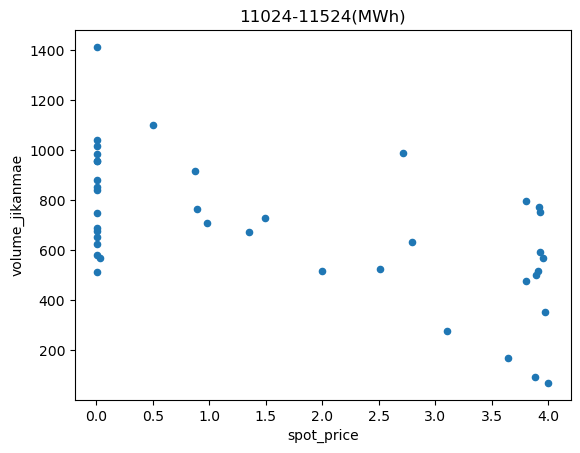

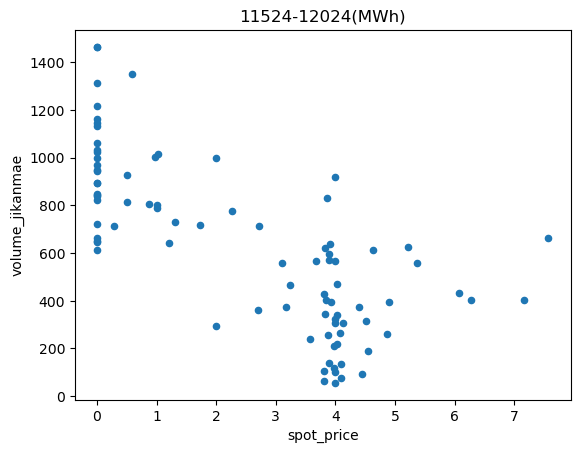

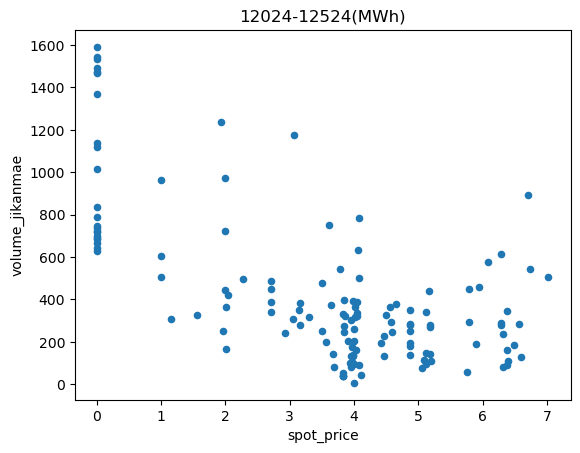

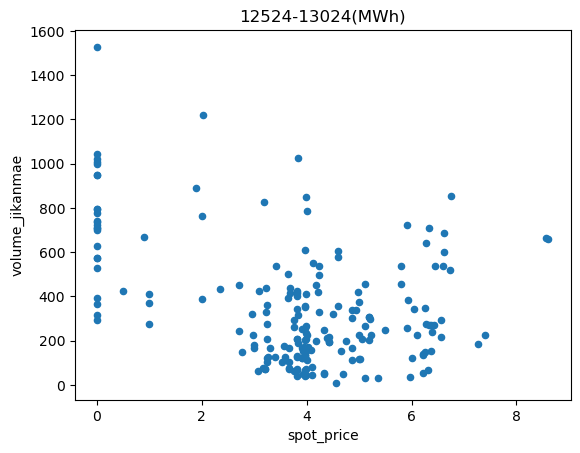

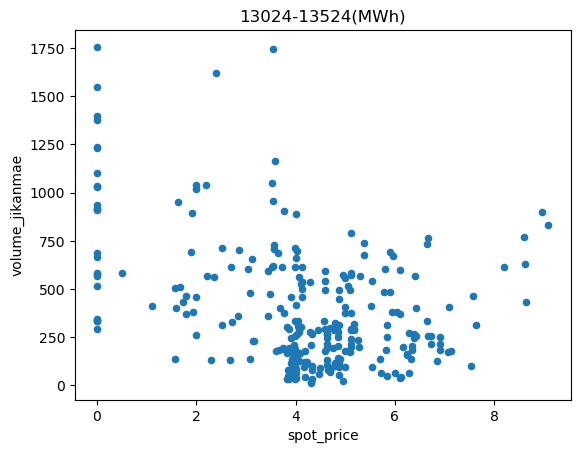

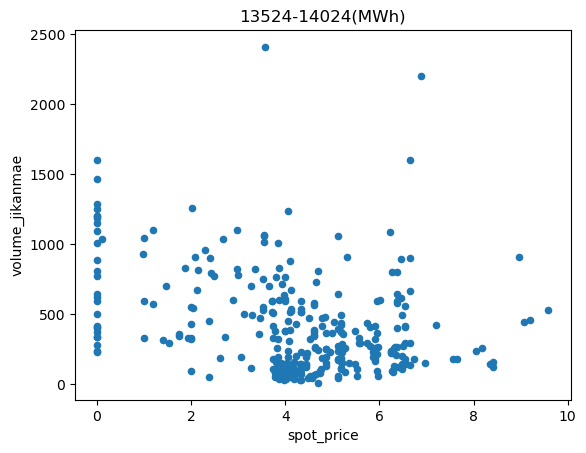

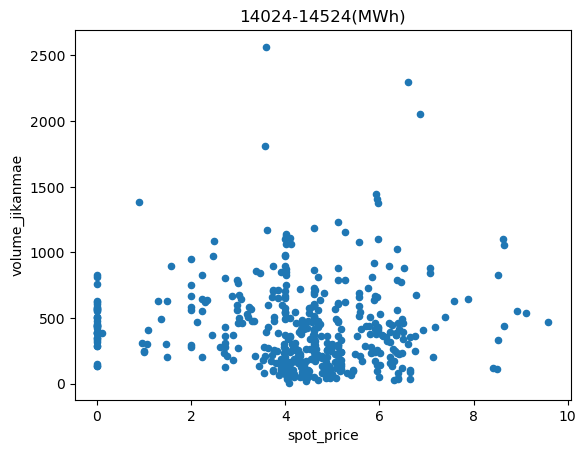

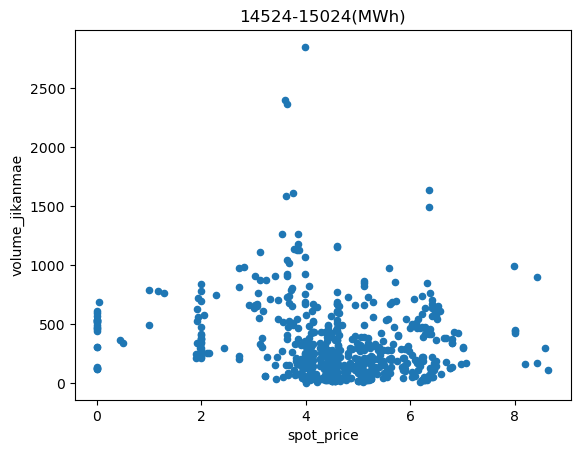

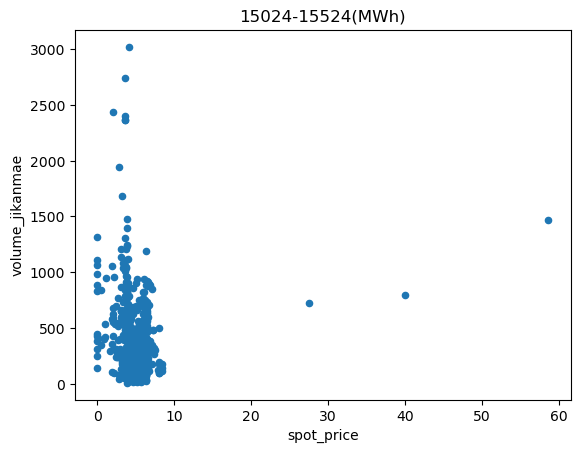

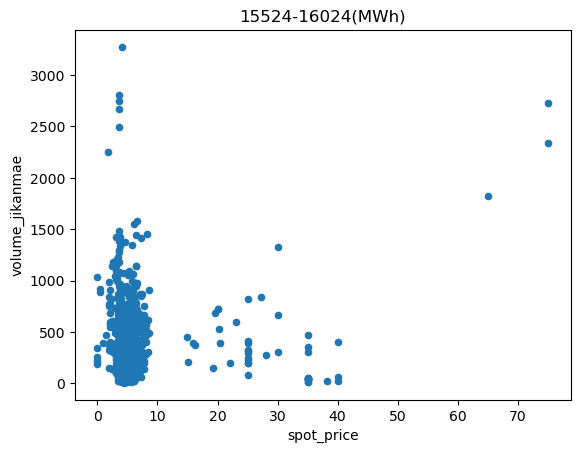

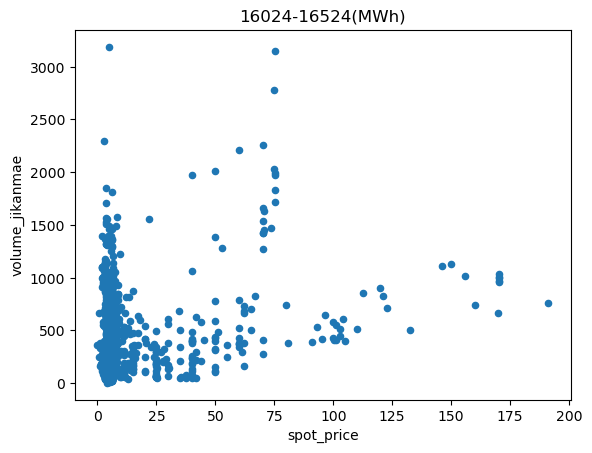

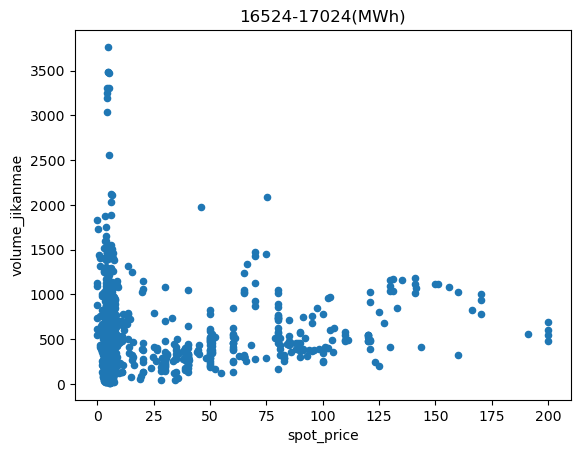

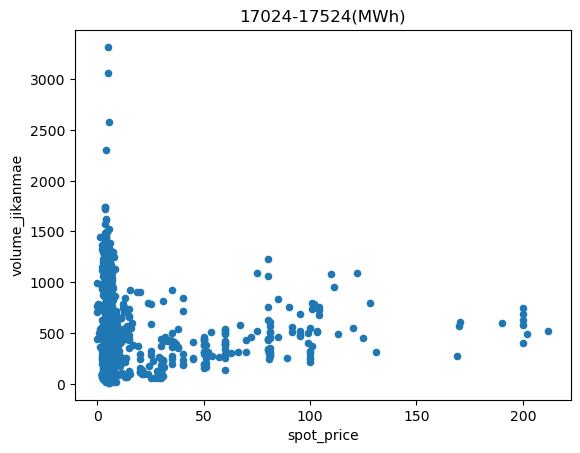

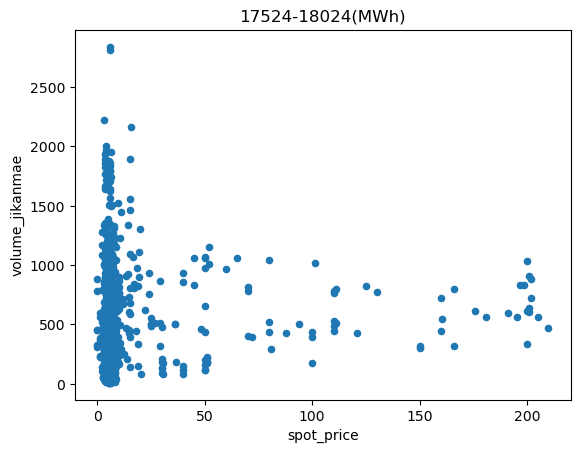

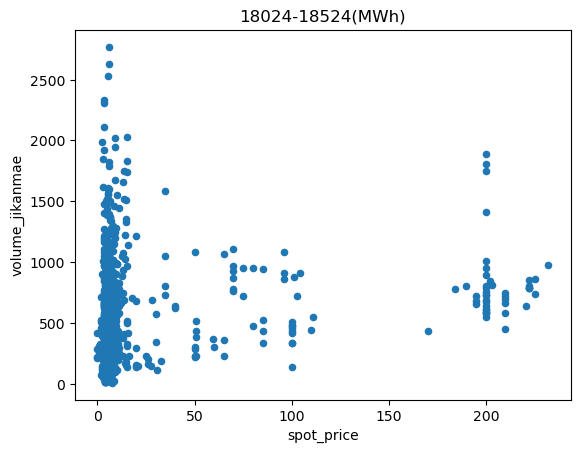

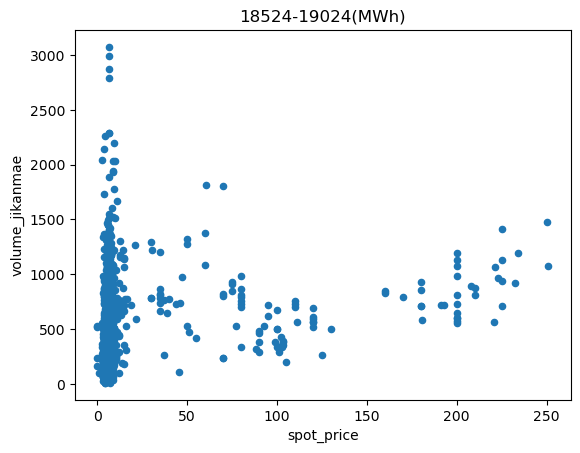

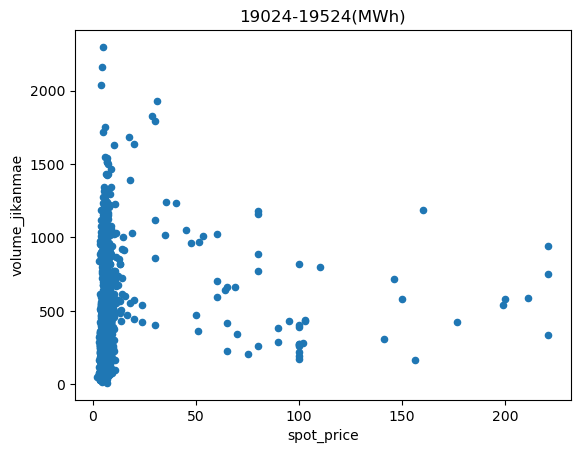

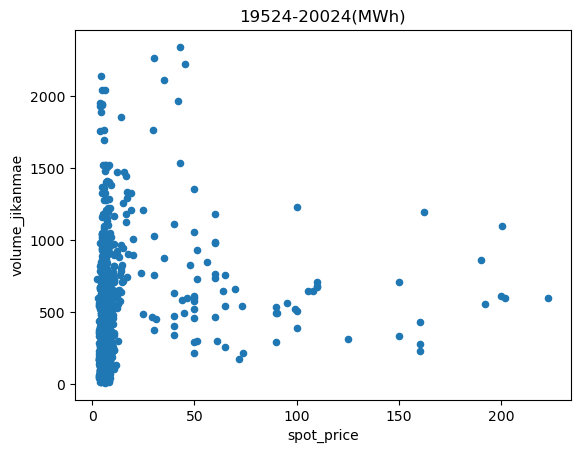

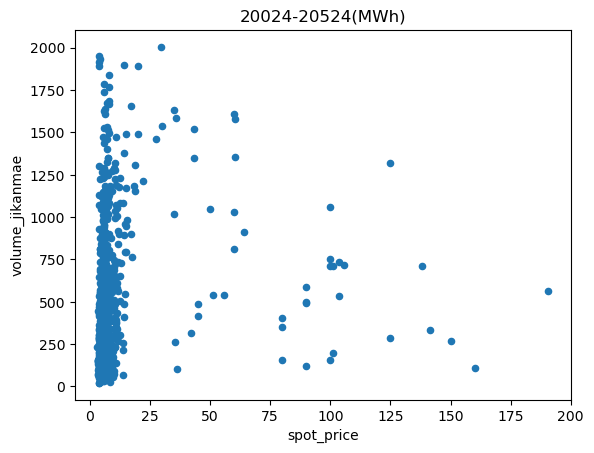

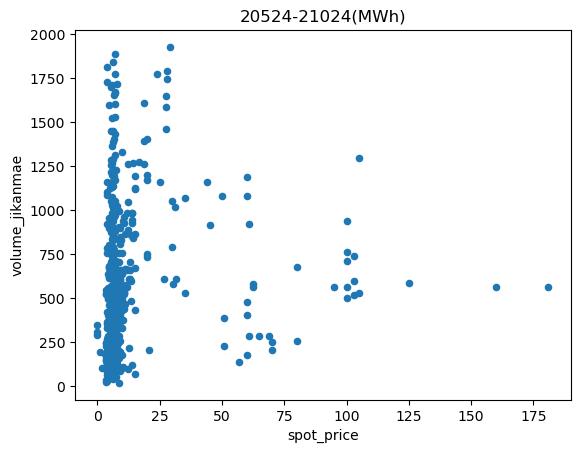

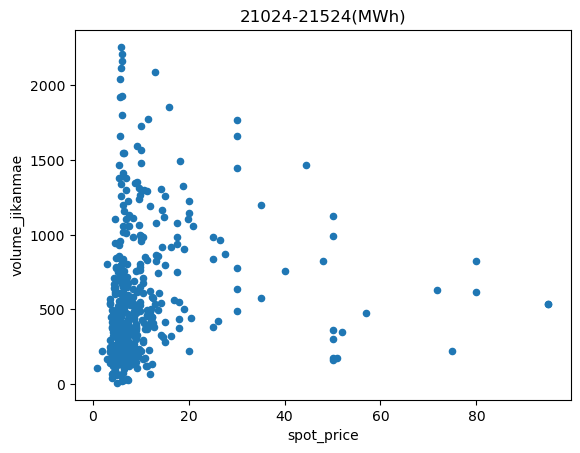

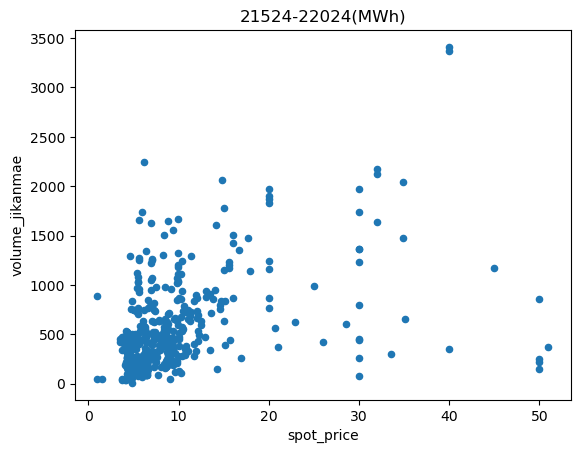

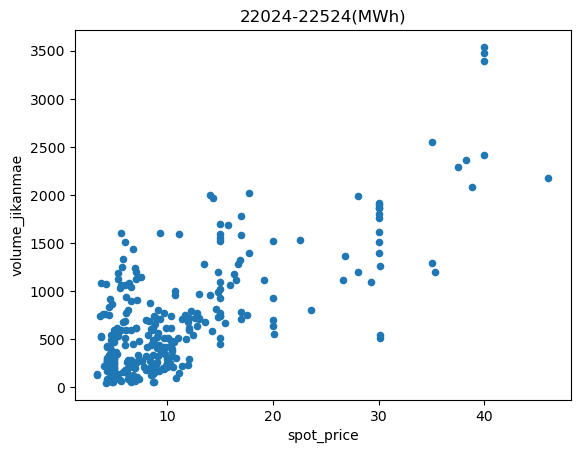

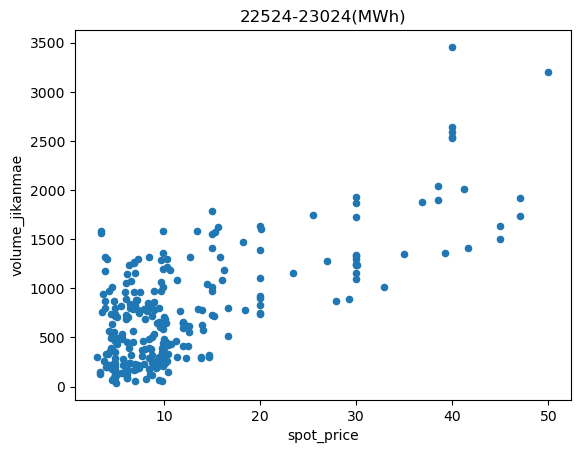

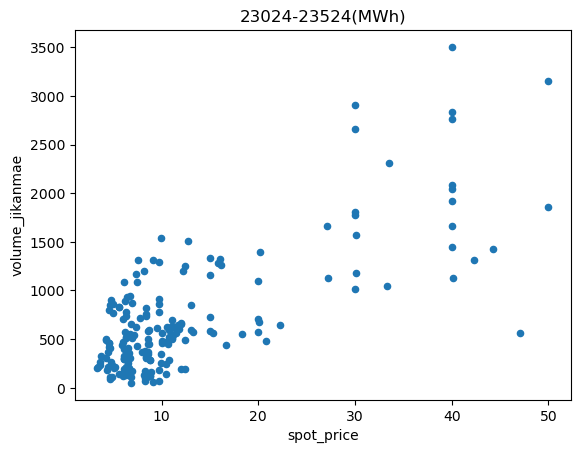

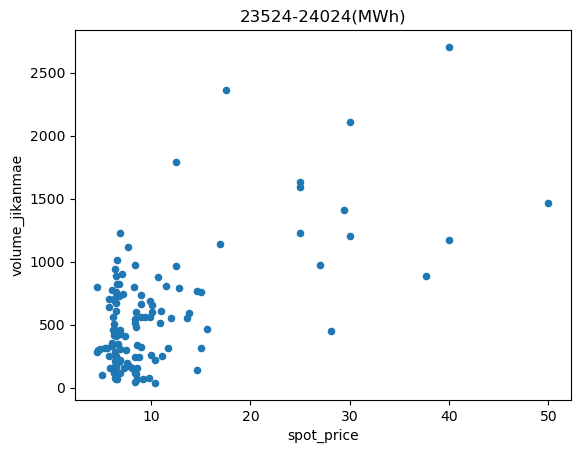

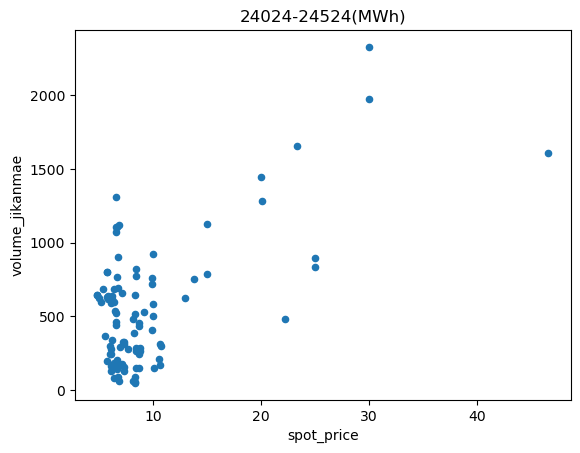

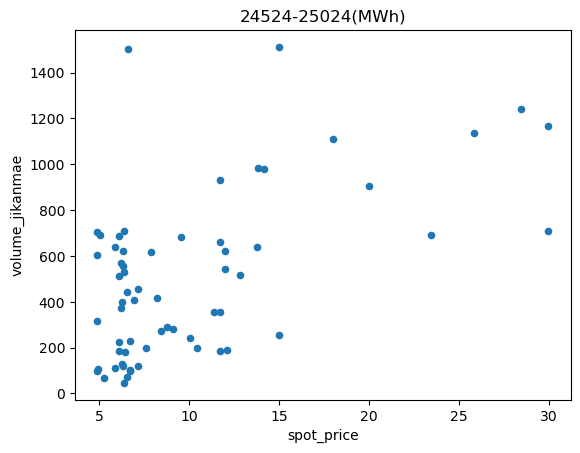

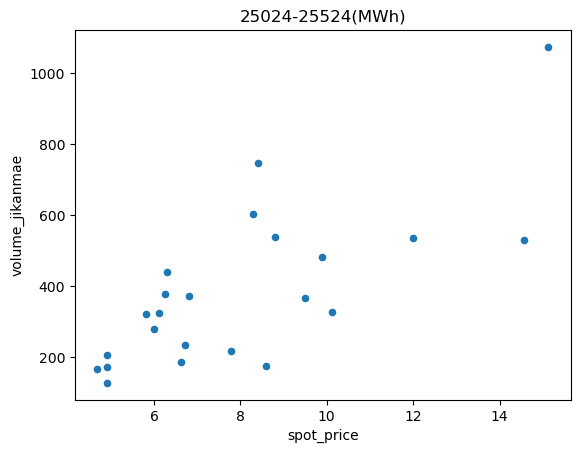

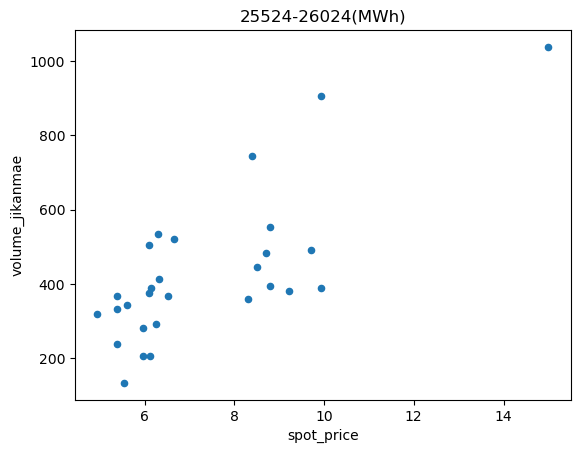

In [218]:
volume_spot = df_merge['volume_spot'].values
min_volume_spot =np.min(volume_spot)
max_volume_spot = np.max(volume_spot)
# 1000MWhずつのとき1000*1000
MWh_range = 500*1000
plot_num =int((max_volume_spot-min_volume_spot)/MWh_range)

for num in range(0,plot_num):

    start_point = min_volume_spot+MWh_range*num
    end_point=min_volume_spot+MWh_range*(num+1)
    df_select = df_merge[(df_merge['volume_spot']>= start_point ) & (df_merge['volume_spot']<= end_point)]

    df_select.plot.scatter(x='spot_price',y='volume_jikanmae',title=f'{int(start_point/1000)}-{int(end_point/1000)}(MWh)')
    plt.savefig(f'/Users/yusuke_miyazaki/Desktop/share_images/share_images_spot_jikanmae2020/figure{num}.png')
    plt.show()

    

In [87]:
num

30

In [78]:
volume_spot = df_merge['volume_spot'].values

In [79]:
print(len(volume_spot),np.min(volume_spot),np.max(volume_spot))

10446 9637300 25165950


In [80]:
(np.max(volume_spot) - np.min(volume_spot))/150/1000

103.52433333333333

In [81]:
min_volume_spot =np.min(volume_spot)

# 1000MWhずつ
df_select = df_merge[(df_merge['volume_spot']>= min_volume_spot) & (df_merge['volume_spot']<= min_volume_spot+1000000)]

<AxesSubplot: xlabel='spot_price', ylabel='volume_jikanmae'>

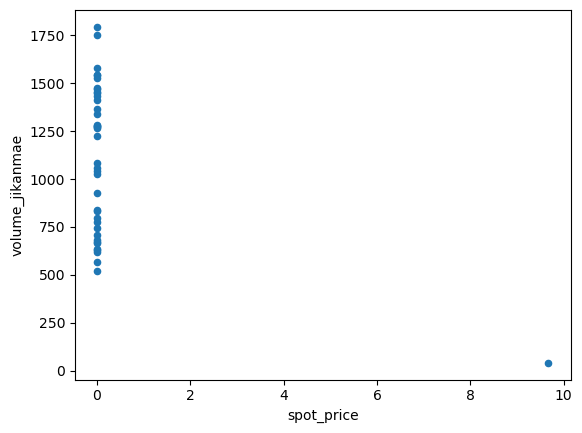

In [82]:
df_select.plot.scatter(x='spot_price',y='volume_jikanmae')

In [55]:
df_spot.columns

Index(['年月日', '時刻コード', '売り入札量(kWh)', '買い入札量(kWh)', 'volume_spot', 'spot_plice',
       'エリアプライス北海道(円/kWh)', 'エリアプライス東北(円/kWh)', 'エリアプライス東京(円/kWh)',
       'エリアプライス中部(円/kWh)', 'エリアプライス北陸(円/kWh)', 'エリアプライス関西(円/kWh)',
       'エリアプライス中国(円/kWh)', 'エリアプライス四国(円/kWh)', 'エリアプライス九州(円/kWh)',
       'Unnamed: 15', 'スポット・時間前平均価格(円/kWh)', 'α上限値×スポット・時間前平均価格(円/kWh)',
       'α下限値×スポット・時間前平均価格(円/kWh)', 'α速報値×スポット・時間前平均価格(円/kWh)',
       'α確報値×スポット・時間前平均価格(円/kWh)', 'Unnamed: 21', '回避可能原価全国値(円/kWh)',
       '回避可能原価北海道(円/kWh)', '回避可能原価東北(円/kWh)', '回避可能原価東京(円/kWh)',
       '回避可能原価中部(円/kWh)', '回避可能原価北陸(円/kWh)', '回避可能原価関西(円/kWh)',
       '回避可能原価中国(円/kWh)', '回避可能原価四国(円/kWh)', '回避可能原価九州(円/kWh)', 'Unnamed: 32',
       '売りブロック入札総量(kWh)', '売りブロック約定総量(kWh)', '買いブロック入札総量(kWh)',
       '買いブロック約定総量(kWh)', 'Unnamed: 37', 'FIP参照価格（卸電力取引市場分）全国値(円/kWh)',
       'FIP参照価格（卸電力取引市場分）北海道(円/kWh)', 'FIP参照価格（卸電力取引市場分）東北(円/kWh)',
       'FIP参照価格（卸電力取引市場分）東京(円/kWh)', 'FIP参照価格（卸電力取引市場分）中部(円/kWh)',
       'FIP参照価格（卸電力取引市場分）北陸(円/kWh

<AxesSubplot: title={'center': 'SPOT_2022_kakaku(yen/kWh)_trihikiryou(kWh)'}, xlabel='Spot_Plice', ylabel='volume_Spot'>

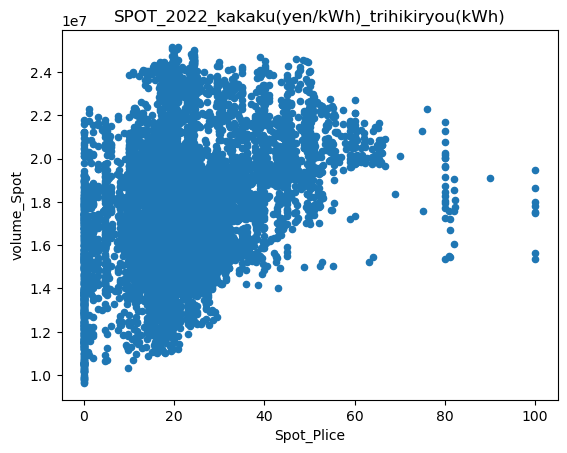

In [45]:

df_spot.plot.scatter(title='SPOT_2022_kakaku(yen/kWh)_trihikiryou(kWh)',x='Spot_Plice',y='volume_Spot')



In [46]:
df_jikanmae

,年月日,時刻コード,始値（円/kWh）,高値（円/kWh）,安値（円/kWh）,終値（円/kWh）,平均（円/kWh）,約定量合計（MWh/h）,約定件数,Datetimes
0,2022/04/01,1,11.78,33.67,3.00,17.50,22.79,337.6,61,2022/04/01_1
1,2022/04/01,2,14.47,20.00,14.00,17.50,15.66,154.8,58,2022/04/01_2
2,2022/04/01,3,25.32,26.32,5.00,14.95,20.79,171.1,64,2022/04/01_3
3,2022/04/01,4,17.55,19.50,12.32,18.55,17.36,154.8,56,2022/04/01_4
4,2022/04/01,5,25.32,26.32,14.00,17.50,21.51,171.5,61,2022/04/01_5
...,...,...,...,...,...,...,...,...,...,...
10441,2022/11/04,26,0.01,23.00,0.01,18.62,19.42,570.0,102,2022/11/04_26
10442,2022/11/04,27,1.00,29.50,1.00,23.90,24.62,246.9,69,2022/11/04_27
10443,2022/11/04,28,71.35,71.35,10.29,28.01,31.72,134.9,53,2022/11/04_28
10444,2022/11/04,29,57.85,57.85,19.68,28.62,30.00,152.1,68,2022/11/04_29


2022


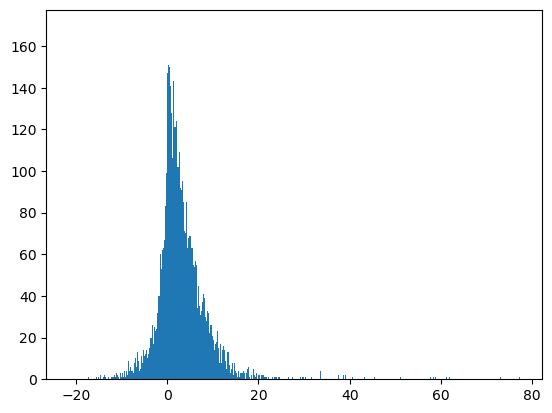

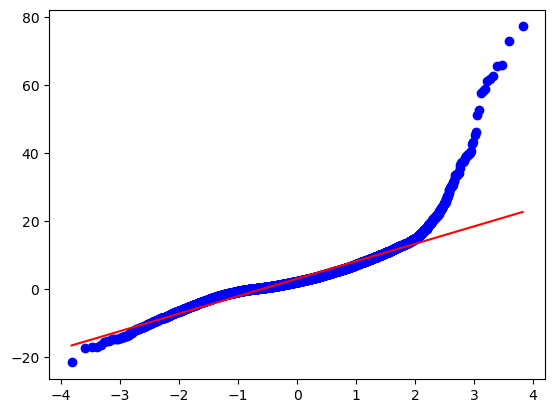

In [53]:
# hist グラム
print(year)
# df_merge.plot.scatter(x='Spot_Plice',y='volume_jikanmae')


jikanmae_spot_price = df_merge['平均（円/kWh）'].values - df_merge['spot_plice'].values

plt.hist(jikanmae_spot_price,bins=1000)
plt.show()

stats.probplot(jikanmae_spot_price, dist="norm" , plot=plt)

plt.show()


<AxesSubplot: xlabel='Spot_Plice', ylabel='volume_jikanmae'>

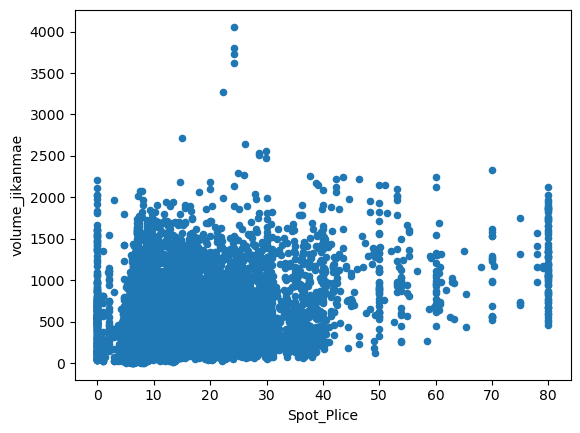

In [24]:
df_merge.plot.scatter(x='Spot_Plice',y='volume_jikanmae')


In [14]:
jikanmae_spot_price = df_merge['平均（円/kWh）'].values - df_merge['Spot_Plice'].values

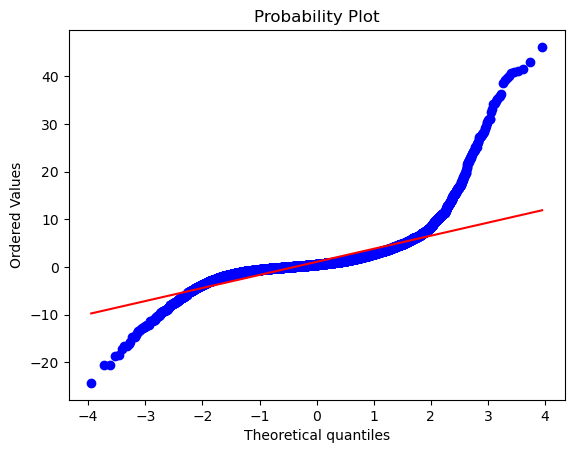

In [18]:
stats.probplot(jikanmae_spot_price, dist="norm" , plot=plt)
plt.show()

In [83]:
df_jikanmae.merge(df_spot,on='Datetimes')

,年月日_x,時刻コード_x,始値（円/kWh）,高値（円/kWh）,安値（円/kWh）,終値（円/kWh）,平均（円/kWh）,約定量合計（MWh/h）,約定件数,Datetimes,...,FIP参照価格（卸電力取引市場分）全国値(円/kWh),FIP参照価格（卸電力取引市場分）北海道(円/kWh),FIP参照価格（卸電力取引市場分）東北(円/kWh),FIP参照価格（卸電力取引市場分）東京(円/kWh),FIP参照価格（卸電力取引市場分）中部(円/kWh),FIP参照価格（卸電力取引市場分）北陸(円/kWh),FIP参照価格（卸電力取引市場分）関西(円/kWh),FIP参照価格（卸電力取引市場分）中国(円/kWh),FIP参照価格（卸電力取引市場分）四国(円/kWh),FIP参照価格（卸電力取引市場分）九州(円/kWh)
0,2022/04/01,1,11.78,33.67,3.00,17.50,22.79,337.6,61,2022/04/01_1,...,12.08,10.41,10.41,12.14,12.13,12.13,12.57,12.15,12.12,12.22
1,2022/04/01,2,14.47,20.00,14.00,17.50,15.66,154.8,58,2022/04/01_2,...,14.48,14.51,14.47,14.48,14.49,14.47,14.47,14.47,14.47,14.47
2,2022/04/01,3,25.32,26.32,5.00,14.95,20.79,171.1,64,2022/04/01_3,...,15.03,24.25,24.32,24.32,14.49,14.49,14.49,14.50,14.49,14.49
3,2022/04/01,4,17.55,19.50,12.32,18.55,17.36,154.8,56,2022/04/01_4,...,16.55,16.56,16.55,16.55,16.56,16.55,16.55,16.56,16.55,16.55
4,2022/04/01,5,25.32,26.32,14.00,17.50,21.51,171.5,61,2022/04/01_5,...,17.32,24.32,24.32,24.32,16.55,16.54,16.54,16.55,16.55,16.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10441,2022/11/04,26,0.01,23.00,0.01,18.62,19.42,570.0,102,2022/11/04_26,...,10.14,18.53,18.52,18.54,18.52,18.53,18.52,18.75,18.52,0.02
10442,2022/11/04,27,1.00,29.50,1.00,23.90,24.62,246.9,69,2022/11/04_27,...,19.18,23.93,23.90,23.93,23.91,23.89,23.90,18.60,18.60,0.01
10443,2022/11/04,28,71.35,71.35,10.29,28.01,31.72,134.9,53,2022/11/04_28,...,19.19,28.01,28.01,28.08,28.01,28.01,28.01,18.56,18.56,12.06
10444,2022/11/04,29,57.85,57.85,19.68,28.62,30.00,152.1,68,2022/11/04_29,...,20.04,28.62,28.67,28.63,28.62,28.62,28.62,20.23,20.23,19.14


In [44]:
df_spot

,年月日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),...,FIP参照価格（卸電力取引市場分）北海道(円/kWh),FIP参照価格（卸電力取引市場分）東北(円/kWh),FIP参照価格（卸電力取引市場分）東京(円/kWh),FIP参照価格（卸電力取引市場分）中部(円/kWh),FIP参照価格（卸電力取引市場分）北陸(円/kWh),FIP参照価格（卸電力取引市場分）関西(円/kWh),FIP参照価格（卸電力取引市場分）中国(円/kWh),FIP参照価格（卸電力取引市場分）四国(円/kWh),FIP参照価格（卸電力取引市場分）九州(円/kWh),Datetimes
0,2022/04/01,1,17007100,16995100,15959150,11.97,10.39,10.39,12.12,12.12,...,10.41,10.41,12.14,12.13,12.13,12.57,12.15,12.12,12.22,2022/04/01_1
1,2022/04/01,2,17252550,17306150,15896600,14.47,14.47,14.47,14.47,14.47,...,14.51,14.47,14.48,14.49,14.47,14.47,14.47,14.47,14.47,2022/04/01_2
2,2022/04/01,3,17496550,17531950,15988650,15.00,24.32,24.32,24.32,14.49,...,24.25,24.32,24.32,14.49,14.49,14.49,14.50,14.49,14.49,2022/04/01_3
3,2022/04/01,4,17994700,17695250,16003200,16.55,16.55,16.55,16.55,16.55,...,16.56,16.55,16.55,16.56,16.55,16.55,16.56,16.55,16.55,2022/04/01_4
4,2022/04/01,5,18144250,17845100,16073050,17.30,24.32,24.32,24.32,16.55,...,24.32,24.32,24.32,16.55,16.54,16.54,16.55,16.55,16.55,2022/04/01_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,2022/11/05,44,19465300,19827000,15867000,27.70,28.12,28.12,28.12,28.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_44
10508,2022/11/05,45,19093000,19586350,15635750,27.63,28.14,28.14,28.14,28.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_45
10509,2022/11/05,46,19002150,19261900,15656250,26.56,27.54,27.54,27.54,27.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_46
10510,2022/11/05,47,18692900,18706600,15644200,25.28,27.33,27.33,27.33,27.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_47


In [45]:
df_jikanmae

,年月日,時刻コード,始値（円/kWh）,高値（円/kWh）,安値（円/kWh）,終値（円/kWh）,平均（円/kWh）,約定量合計（MWh/h）,約定件数,Datetimes
0,2022/04/01,1,11.78,33.67,3.00,17.50,22.79,337.6,61,2022/04/01_1
1,2022/04/01,2,14.47,20.00,14.00,17.50,15.66,154.8,58,2022/04/01_2
2,2022/04/01,3,25.32,26.32,5.00,14.95,20.79,171.1,64,2022/04/01_3
3,2022/04/01,4,17.55,19.50,12.32,18.55,17.36,154.8,56,2022/04/01_4
4,2022/04/01,5,25.32,26.32,14.00,17.50,21.51,171.5,61,2022/04/01_5
...,...,...,...,...,...,...,...,...,...,...
10441,2022/11/04,26,0.01,23.00,0.01,18.62,19.42,570.0,102,2022/11/04_26
10442,2022/11/04,27,1.00,29.50,1.00,23.90,24.62,246.9,69,2022/11/04_27
10443,2022/11/04,28,71.35,71.35,10.29,28.01,31.72,134.9,53,2022/11/04_28
10444,2022/11/04,29,57.85,57.85,19.68,28.62,30.00,152.1,68,2022/11/04_29


In [69]:
datetimes_spot = np.array(df_spot['Datetimes'].values,dtype='str')
datetimes_jikanmae =np.array(df_jikanmae['Datetimes'].values, dtype='str')

common_datetimes = np.intersect1d(datetimes_spot,datetimes_jikanmae)


In [78]:
common_datetimes[-100:]

array(['2022/11/02_33', '2022/11/02_34', '2022/11/02_35', '2022/11/02_36',
       '2022/11/02_37', '2022/11/02_38', '2022/11/02_39', '2022/11/02_4',
       '2022/11/02_40', '2022/11/02_41', '2022/11/02_42', '2022/11/02_43',
       '2022/11/02_44', '2022/11/02_45', '2022/11/02_46', '2022/11/02_47',
       '2022/11/02_48', '2022/11/02_5', '2022/11/02_6', '2022/11/02_7',
       '2022/11/02_8', '2022/11/02_9', '2022/11/03_1', '2022/11/03_10',
       '2022/11/03_11', '2022/11/03_12', '2022/11/03_13', '2022/11/03_14',
       '2022/11/03_15', '2022/11/03_16', '2022/11/03_17', '2022/11/03_18',
       '2022/11/03_19', '2022/11/03_2', '2022/11/03_20', '2022/11/03_21',
       '2022/11/03_22', '2022/11/03_23', '2022/11/03_24', '2022/11/03_25',
       '2022/11/03_26', '2022/11/03_27', '2022/11/03_28', '2022/11/03_29',
       '2022/11/03_3', '2022/11/03_30', '2022/11/03_31', '2022/11/03_32',
       '2022/11/03_33', '2022/11/03_34', '2022/11/03_35', '2022/11/03_36',
       '2022/11/03_37', '2022/11/0

In [67]:
datetimes_jikanmae

array(['2022/04/01_1', '2022/04/01_2', '2022/04/01_3', ...,
       '2022/11/04_28', '2022/11/04_29', '2022/11/04_30'], dtype=object)

In [68]:
np.array(common_datetimes,dtype='str')

array(['2022/04/01_1', '2022/04/01_10', '2022/04/01_11', ...,
       '2022/11/04_7', '2022/11/04_8', '2022/11/04_9'], dtype='<U13')

In [58]:
len(common_datetimes)

10446

In [49]:
df_spot['Datetimes'].values[-100:]

array(['2022/11/03_45', '2022/11/03_46', '2022/11/03_47', '2022/11/03_48',
       '2022/11/04_1', '2022/11/04_2', '2022/11/04_3', '2022/11/04_4',
       '2022/11/04_5', '2022/11/04_6', '2022/11/04_7', '2022/11/04_8',
       '2022/11/04_9', '2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18', '2022/11/04_19', '2022/11/04_20',
       '2022/11/04_21', '2022/11/04_22', '2022/11/04_23', '2022/11/04_24',
       '2022/11/04_25', '2022/11/04_26', '2022/11/04_27', '2022/11/04_28',
       '2022/11/04_29', '2022/11/04_30', '2022/11/04_31', '2022/11/04_32',
       '2022/11/04_33', '2022/11/04_34', '2022/11/04_35', '2022/11/04_36',
       '2022/11/04_37', '2022/11/04_38', '2022/11/04_39', '2022/11/04_40',
       '2022/11/04_41', '2022/11/04_42', '2022/11/04_43', '2022/11/04_44',
       '2022/11/04_45', '2022/11/04_46', '2022/11/04_47', '2022/11/04_48',
       '2022/11/05_1', '2022/11/05

In [50]:
df_jikanmae['Datetimes'].values[-100:]

array(['2022/11/02_27', '2022/11/02_28', '2022/11/02_29', '2022/11/02_30',
       '2022/11/02_31', '2022/11/02_32', '2022/11/02_33', '2022/11/02_34',
       '2022/11/02_35', '2022/11/02_36', '2022/11/02_37', '2022/11/02_38',
       '2022/11/02_39', '2022/11/02_40', '2022/11/02_41', '2022/11/02_42',
       '2022/11/02_43', '2022/11/02_44', '2022/11/02_45', '2022/11/02_46',
       '2022/11/02_47', '2022/11/02_48', '2022/11/03_1', '2022/11/03_2',
       '2022/11/03_3', '2022/11/03_4', '2022/11/03_5', '2022/11/03_6',
       '2022/11/03_7', '2022/11/03_8', '2022/11/03_9', '2022/11/03_10',
       '2022/11/03_11', '2022/11/03_12', '2022/11/03_13', '2022/11/03_14',
       '2022/11/03_15', '2022/11/03_16', '2022/11/03_17', '2022/11/03_18',
       '2022/11/03_19', '2022/11/03_20', '2022/11/03_21', '2022/11/03_22',
       '2022/11/03_23', '2022/11/03_24', '2022/11/03_25', '2022/11/03_26',
       '2022/11/03_27', '2022/11/03_28', '2022/11/03_29', '2022/11/03_30',
       '2022/11/03_31', '2022/11/0

In [62]:
np.intersect1d(df_spot['Datetimes'].values[-100:],df_jikanmae['Datetimes'][-100:].values)

array(['2022/11/03_45', '2022/11/03_46', '2022/11/03_47', '2022/11/03_48',
       '2022/11/04_1', '2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18', '2022/11/04_19', '2022/11/04_2',
       '2022/11/04_20', '2022/11/04_21', '2022/11/04_22', '2022/11/04_23',
       '2022/11/04_24', '2022/11/04_25', '2022/11/04_26', '2022/11/04_27',
       '2022/11/04_28', '2022/11/04_29', '2022/11/04_3', '2022/11/04_30',
       '2022/11/04_4', '2022/11/04_5', '2022/11/04_6', '2022/11/04_7',
       '2022/11/04_8', '2022/11/04_9'], dtype=object)

In [63]:
test1 =['2022/11/04_10',
       '2022/11/04_11', '2022/11/04_12', '2022/11/04_13']

In [64]:
test2 = ['2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18']

In [65]:
np.intersect1d(np.array(test1),np.array(test2))

array(['2022/11/04_10', '2022/11/04_11', '2022/11/04_12', '2022/11/04_13'],
      dtype='<U13')

In [75]:
np.intersect1d(datetimes_spot[-100:-50],datetimes_jikanmae[-50:])

array(['2022/11/03_45', '2022/11/03_46', '2022/11/03_47', '2022/11/03_48',
       '2022/11/04_1', '2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18', '2022/11/04_19', '2022/11/04_2',
       '2022/11/04_20', '2022/11/04_21', '2022/11/04_22', '2022/11/04_23',
       '2022/11/04_24', '2022/11/04_25', '2022/11/04_26', '2022/11/04_27',
       '2022/11/04_28', '2022/11/04_29', '2022/11/04_3', '2022/11/04_30',
       '2022/11/04_4', '2022/11/04_5', '2022/11/04_6', '2022/11/04_7',
       '2022/11/04_8', '2022/11/04_9'], dtype='<U13')

In [76]:
datetimes_spot[-100:-50]

array(['2022/11/03_45', '2022/11/03_46', '2022/11/03_47', '2022/11/03_48',
       '2022/11/04_1', '2022/11/04_2', '2022/11/04_3', '2022/11/04_4',
       '2022/11/04_5', '2022/11/04_6', '2022/11/04_7', '2022/11/04_8',
       '2022/11/04_9', '2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18', '2022/11/04_19', '2022/11/04_20',
       '2022/11/04_21', '2022/11/04_22', '2022/11/04_23', '2022/11/04_24',
       '2022/11/04_25', '2022/11/04_26', '2022/11/04_27', '2022/11/04_28',
       '2022/11/04_29', '2022/11/04_30', '2022/11/04_31', '2022/11/04_32',
       '2022/11/04_33', '2022/11/04_34', '2022/11/04_35', '2022/11/04_36',
       '2022/11/04_37', '2022/11/04_38', '2022/11/04_39', '2022/11/04_40',
       '2022/11/04_41', '2022/11/04_42', '2022/11/04_43', '2022/11/04_44',
       '2022/11/04_45', '2022/11/04_46'], dtype='<U13')

In [77]:
datetimes_spot[-100:]

array(['2022/11/03_45', '2022/11/03_46', '2022/11/03_47', '2022/11/03_48',
       '2022/11/04_1', '2022/11/04_2', '2022/11/04_3', '2022/11/04_4',
       '2022/11/04_5', '2022/11/04_6', '2022/11/04_7', '2022/11/04_8',
       '2022/11/04_9', '2022/11/04_10', '2022/11/04_11', '2022/11/04_12',
       '2022/11/04_13', '2022/11/04_14', '2022/11/04_15', '2022/11/04_16',
       '2022/11/04_17', '2022/11/04_18', '2022/11/04_19', '2022/11/04_20',
       '2022/11/04_21', '2022/11/04_22', '2022/11/04_23', '2022/11/04_24',
       '2022/11/04_25', '2022/11/04_26', '2022/11/04_27', '2022/11/04_28',
       '2022/11/04_29', '2022/11/04_30', '2022/11/04_31', '2022/11/04_32',
       '2022/11/04_33', '2022/11/04_34', '2022/11/04_35', '2022/11/04_36',
       '2022/11/04_37', '2022/11/04_38', '2022/11/04_39', '2022/11/04_40',
       '2022/11/04_41', '2022/11/04_42', '2022/11/04_43', '2022/11/04_44',
       '2022/11/04_45', '2022/11/04_46', '2022/11/04_47', '2022/11/04_48',
       '2022/11/05_1', '2022/11/05

In [15]:
Time_code

array([ 1,  2,  3, ..., 46, 47, 48])

In [18]:
Date_time_list = []
for i in range(len(df)):
    Date_time = f'{Date_list[i]}_{Time_code[i]}'
    Date_time_list.append(Date_time)

In [21]:
def Create_DateTime(df):
    df = df.copy()
    Date_list = df['年月日'].values
    Time_code = df['時刻コード'].values
    # 年月日と時刻コードを連結して
    Date_time_list = []
    for i in range(len(df)):
        Date_time = f'{Date_list[i]}_{Time_code[i]}'
        Date_time_list.append(Date_time)

    df['Datetimes'] = Date_time_list
    return(df)

In [22]:
df_spot_2022 = Create_DateTime(df_spot_2022)


In [23]:
df_spot_2022

,年月日,時刻コード,売り入札量(kWh),買い入札量(kWh),約定総量(kWh),システムプライス(円/kWh),エリアプライス北海道(円/kWh),エリアプライス東北(円/kWh),エリアプライス東京(円/kWh),エリアプライス中部(円/kWh),...,FIP参照価格（卸電力取引市場分）北海道(円/kWh),FIP参照価格（卸電力取引市場分）東北(円/kWh),FIP参照価格（卸電力取引市場分）東京(円/kWh),FIP参照価格（卸電力取引市場分）中部(円/kWh),FIP参照価格（卸電力取引市場分）北陸(円/kWh),FIP参照価格（卸電力取引市場分）関西(円/kWh),FIP参照価格（卸電力取引市場分）中国(円/kWh),FIP参照価格（卸電力取引市場分）四国(円/kWh),FIP参照価格（卸電力取引市場分）九州(円/kWh),Datetimes
0,2022/04/01,1,17007100,16995100,15959150,11.97,10.39,10.39,12.12,12.12,...,10.41,10.41,12.14,12.13,12.13,12.57,12.15,12.12,12.22,2022/04/01_1
1,2022/04/01,2,17252550,17306150,15896600,14.47,14.47,14.47,14.47,14.47,...,14.51,14.47,14.48,14.49,14.47,14.47,14.47,14.47,14.47,2022/04/01_2
2,2022/04/01,3,17496550,17531950,15988650,15.00,24.32,24.32,24.32,14.49,...,24.25,24.32,24.32,14.49,14.49,14.49,14.50,14.49,14.49,2022/04/01_3
3,2022/04/01,4,17994700,17695250,16003200,16.55,16.55,16.55,16.55,16.55,...,16.56,16.55,16.55,16.56,16.55,16.55,16.56,16.55,16.55,2022/04/01_4
4,2022/04/01,5,18144250,17845100,16073050,17.30,24.32,24.32,24.32,16.55,...,24.32,24.32,24.32,16.55,16.54,16.54,16.55,16.55,16.55,2022/04/01_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,2022/11/05,44,19465300,19827000,15867000,27.70,28.12,28.12,28.12,28.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_44
10508,2022/11/05,45,19093000,19586350,15635750,27.63,28.14,28.14,28.14,28.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_45
10509,2022/11/05,46,19002150,19261900,15656250,26.56,27.54,27.54,27.54,27.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_46
10510,2022/11/05,47,18692900,18706600,15644200,25.28,27.33,27.33,27.33,27.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022/11/05_47
